# Some imports

In [1]:
from scipy import signal # Signal Processing Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # DataBase management
import seaborn # Improve Images
from statsmodels.tsa.ar_model import AR, ARResults
%matplotlib inline

# Feature Engineering

In [2]:
## Column Names ##
nm = ['ind', 'ax', 'ay', 'az', 'label'] # Names of columns
acc_nm = ['ax', 'ay', 'az'] # Names of signal features
## Load Dataset
link = "Dataset/1.csv"
def loadDB(link):
    "A function that import the database from Dataset folder and return df"
    
    label2str = {1:'Work. Comp.', 2:'Stand. Walk. & Go. up-do', 
                 3:'Standing', 4:'Walking',5:'Go Up\Do', 6:'Walk. & Talk. Someone', 
                 7:'Talking while Standing'}
    df = pd.read_csv(link, sep=',', names=nm)
    del df['ind']
    df = df[df.label != 0] # Unusable row
    df['label_str'] = df.label.apply(lambda x:label2str[x]) # Important to some plots
    return df

df_raw = loadDB(link)
df_raw.head()

,ax,ay,az,label,label_str
0,1502,2215,2153,1,Work. Comp.
1,1667,2072,2047,1,Work. Comp.
2,1611,1957,1906,1,Work. Comp.
3,1601,1939,1831,1,Work. Comp.
4,1643,1965,1879,1,Work. Comp.


In [3]:
def widen_signal(df):
    # Magnitude
    df['mag'] = np.sqrt(np.square(df[acc_nm]).sum(axis=1)) 
    # Median filter - 3rd ordre
    def med_fil(df, names):
        """Filter the signal by a median filter"""
        df_r = pd.DataFrame()
        df = df[names]
        for column in df.columns:
            name = column+'_median'
            df_r[name] = signal.medfilt(df[column].values)
        return df_r
    df_med = med_fil(df, acc_nm)
    # Diffrential
    def diffrential(df, names):
        """Compute the differentials of acceleration - Jerk"""
        df = df[names]
        df_r = df.diff(periods=1, axis=0).fillna(method='backfill')
        df_r.columns = [names[0]+'_diff', names[1]+'_diff', names[2]+'_diff']
        return df_r
    df_diff = diffrential(df, acc_nm)
    # Low pass filter
    def lowpass(df, names):
        """Compute low-pass filter"""
        df = df[names]
        df_r = pd.DataFrame()
        fs = 52 # frequence sampling is 52
        f_cut = 1 # cutoff frequency
        fs_n = f_cut*2.0/fs # normalized frequency
        b,a = signal.butter(N=3, Wn=fs_n, btype='low')
        for column in df.columns : 
            name = column+'_low-p'
            df_r[name] = signal.lfilter(b,a,df[column].values)
        return df_r
    df_lp = lowpass(df, acc_nm)  
    # High pass filter 
    def highpass(df, names):
        """Compute high-pass filter"""
        df = df[names]
        df_r = pd.DataFrame()
        fs = 52 # frequence sampling is 52
        f_cut = 1 # cutoff frequency
        fs_n = f_cut*2.0/fs # normalized frequency
        b,a = signal.butter(N=3, Wn=fs_n, btype='high')
        for column in df.columns : 
            name = column+'_high-p'
            df_r[name] = signal.lfilter(b,a,df[column].values)
        return df_r
    df_hp = highpass(df, acc_nm)

    # Compute the total Total
    df = pd.concat([df, df_med, df_diff, df_lp, df_hp], axis=1)
    return df
df_widen = widen_signal(df_raw)
df_widen.head()

,ax,ay,az,label,label_str,mag,ax_median,ay_median,az_median,ax_diff,ay_diff,az_diff,ax_low-p,ay_low-p,az_low-p,ax_high-p,ay_high-p,az_high-p
0,1502,2215,2153,1,Work. Comp.,3434.768988,1502.0,2072.0,2047.0,165.0,-143.0,-106.0,0.294570,0.434402,0.422243,1330.950456,1962.753168,1907.813802
1,1667,2072,2047,1,Work. Comp.,3355.932359,1611.0,2072.0,2047.0,165.0,-143.0,-106.0,2.023204,2.907854,2.832932,1155.714581,1362.002403,1353.118154
2,1611,1957,1906,1,Work. Comp.,3171.435952,1611.0,1957.0,1906.0,-56.0,-115.0,-141.0,7.011663,9.821684,9.584772,789.314495,875.625099,847.401747
3,1601,1939,1831,1,Work. Comp.,3110.543843,1611.0,1957.0,1879.0,-10.0,-18.0,-75.0,16.960462,23.217970,22.667546,517.382527,551.056967,481.033069
4,1643,1965,1879,1,Work. Comp.,3176.683018,1604.0,1959.0,1879.0,42.0,26.0,48.0,33.066246,44.414894,43.325413,330.972495,313.877533,283.050573


label_str
Go Up\Do                    Axes(0.125,0.125;0.775x0.775)
Stand. Walk. & Go. up-do    Axes(0.125,0.125;0.775x0.775)
Standing                    Axes(0.125,0.125;0.775x0.775)
Talking while Standing      Axes(0.125,0.125;0.775x0.775)
Walk. & Talk. Someone       Axes(0.125,0.125;0.775x0.775)
Walking                     Axes(0.125,0.125;0.775x0.775)
Work. Comp.                 Axes(0.125,0.125;0.775x0.775)
Name: mag, dtype: object

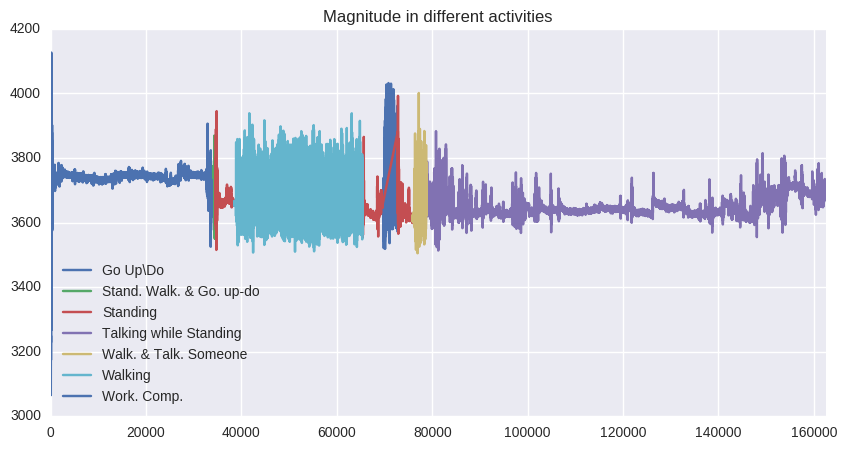

In [4]:
df_widen.groupby('label_str').mag.plot(kind='line', figsize=(10,5), legend=True, title='Magnitude in different activities')

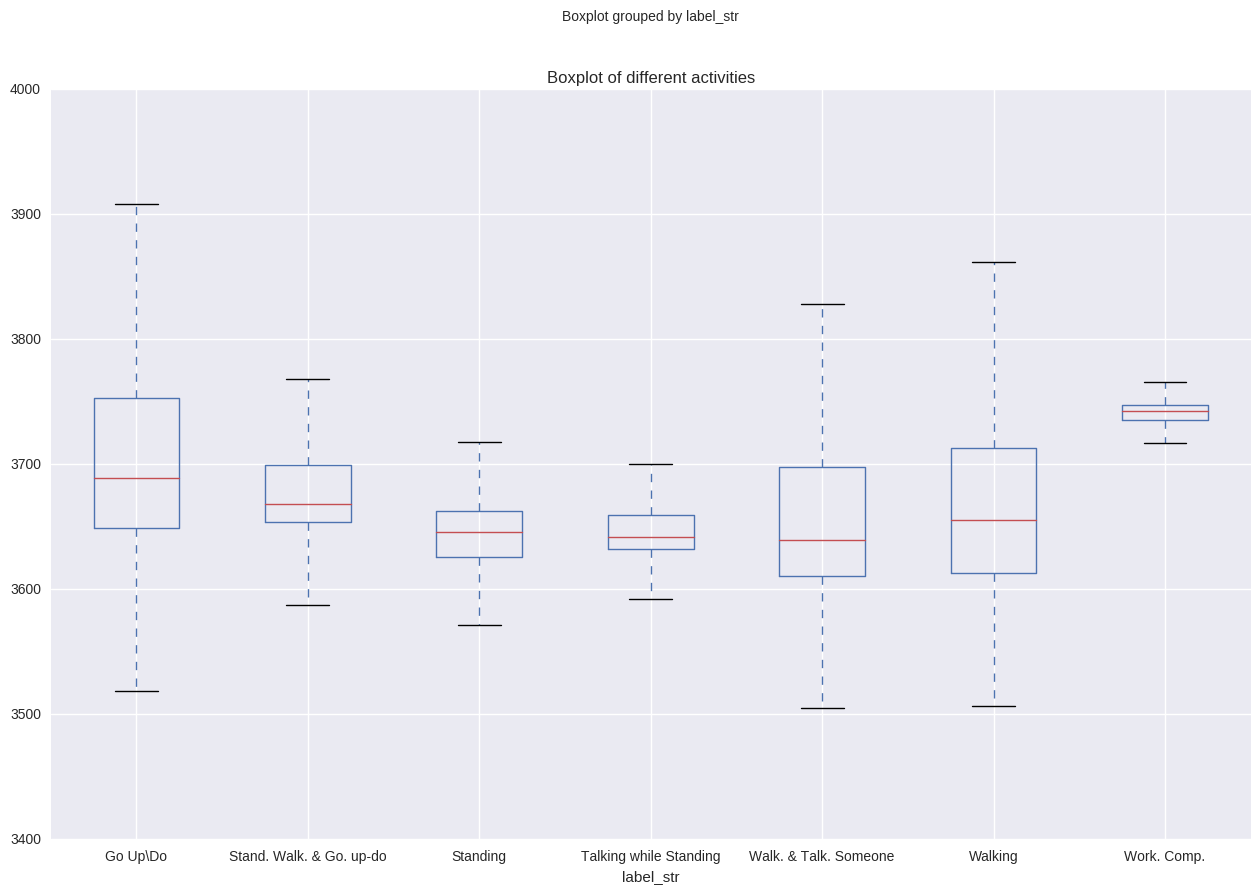

In [5]:
fig = plt.figure(figsize=(15,10))
axis = plt.axes(ylim=(3400,4000))
df_widen.boxplot(by='label_str', column=['mag'], ax=axis, figsize=(10,6))
plt.title('Boxplot of different activities')

In [6]:
def windowing(signal,size,step):
    """Compute the window"""
    d = len(signal) #length of the signal
    nk = int(np.floor((d-size+1)/step))+1 #le nombre de fenetres
    wk = np.zeros((nk,size)) #windows
    for j in range(nk):
        wk[j,:] = signal[j*step:j*step+size]
    return wk
def window_labels(labels,size,step):
    """Compute the label of the window"""
    d = len(labels) #length of the signal
    nk = int(np.floor((d-size+1)/step))+1 #le nombre de fenetres
    labelwk = np.zeros((nk)) #window labels
    for j in range(nk):
        labelwk[j] = np.max(np.argmax(np.bincount(labels[j*step:j*step+size])))
    return labelwk
def extract_windows(df,size,step):
    """
    extract windows with the specified size and step from the dataframe df
    
    Returns:
    L : List of dataframes. Each dataframe contains a window extracted from each signal in df.
    labels: labels of windows
    """
    
    L = []
    n = df.shape[0]
    L_windows = dict()
    n_windows = int(np.floor((n-size+1)/step))+1
    for column in df.columns:
        if column not in ['label','label_str']:
            L_windows[column] = windowing(df[column],size,step)
    for i in range(n_windows):
        ddf = pd.DataFrame()
        for column in df.columns:
            if column not in ['label','label_str']:
                ddf[column] = L_windows[column][i,:]
        L.append(ddf)
    labels = window_labels(df['label'],size,step)
    return L,labels



def compute_features(df):
    """Compute features from a give dataframe"""
    ## Basic Statistics
    m = df.mean(axis=0).values # Mean
    ma = df.mad(axis=0).values # Median
    std = df.std(axis=0).values # Standard Deviation
    var = df.var(axis=0).values # Variance
    minimum = df.min(axis=0).values # Minimum
    maximum = df.max(axis=0).values # Maximum
    skew = df.skew(axis=0).values # Skewness
    kurt = df.kurtosis(axis=0).values # Kurtosis
    inteQ = (df.quantile(q=0.75, axis=0).values - df.quantile(q=0.25, axis=0).values) # Interquantile
    r = np.hstack([m, ma, std, var, minimum, maximum, skew, kurt, inteQ]) # Compute vector of features
    return r


def compute_matrix_data(df, N_samples=52, percentage=0.5):
    """Extract Matrix of data"""
    df_X, df_Y = extract_windows(df,N_samples,int(percentage*N_samples))
    X = compute_features(df_X[0])
    for i in range(1,len(df_X)):
        vec = compute_features(df_X[i])
        X = np.vstack([X,vec])
    
    y = np.array(df_Y) # Compute the vector of labels
    return X, y

X, y = compute_matrix_data(df_widen) # Compute matrix of data
X.shape

(6249, 144)

# Classical algorithms

In [7]:
## Methods
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Ensemble
from sklearn.svm import SVC # SVM
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression # Logistic Regression
## Utils
from sklearn.model_selection import GridSearchCV # Choose parameters
from sklearn.preprocessing import scale # Normalise matrix
from sklearn.metrics import confusion_matrix 
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score

In [8]:
X_train = X
y_train = y
X_train_da, y_train = shuffle(X_train, y_train, random_state=0) # Shuffle data
X_train = scale(X_train_da) # Scale the data for the classical algorithm

In [9]:
lr = LogisticRegressionCV()
lr.fit(X_train, y_train)
cv_lr = min(cross_val_score(lr, X_train, y_train, cv=3))
print("Logistic Regression :"+str(cv_lr))
print("Confusion Matrix : Logistic Reegression")
print(confusion_matrix(y_train, lr.predict(X_train)))

svm = SVC(C=8, kernel='rbf') # Parameters chosen by GridSearh
svm.fit(X_train, y_train)
cv_svm = min(cross_val_score(svm, X_train, y_train, cv=3))
print("SVM :"+str(cv_svm))
print("Confusion Matrix : SVM")
print(confusion_matrix(y_train, svm.predict(X_train)))

gb = GradientBoostingClassifier()
cv_gb = min(cross_val_score(gb, X_train, y_train, cv=3))
gb.fit(X_train, y_train)
print("GradientBoosting :"+str(cv_gb))
print("Confusion Matrix : Gradient Boosting")
print(confusion_matrix(y_train, gb.predict(X_train)))

knn = KNeighborsClassifier() # Parameters chosen by GridSearh
knn.fit(X_train, y_train)
cv_knn = min(cross_val_score(knn, X_train, y_train, cv=3))
print("KNN :"+str(cv_knn))
print("Confusion Matrix : KNN")
print(confusion_matrix(y_train, knn.predict(X_train)))


Logistic Regression :0.884134615385
Confusion Matrix : Logistic Reegression
[[1276    0    0    2    1    0   16]
 [   2    0    0    8    4    3   18]
 [   0    0    0   20    6    6  398]
 [   0    0    0 1010    1    6   16]
 [   1    0    0    3  103    1   15]
 [   0    0    0   33    2   60   17]
 [  57    0    0    1    0    0 3163]]
SVM :0.897743638982
Confusion Matrix : SVM
[[1294    0    0    0    0    0    1]
 [   0   29    0    0    0    0    6]
 [   0    0   84    4    0    0  342]
 [   0    0    0 1021    0    0   12]
 [   0    0    0    0  118    0    5]
 [   0    0    0    2    0   96   14]
 [   2    0    0    0    0    0 3219]]
GradientBoosting :0.913710450623
Confusion Matrix : Gradient Boosting
[[1295    0    0    0    0    0    0]
 [   0   35    0    0    0    0    0]
 [   0    0  353    5    0    0   72]
 [   0    0    3 1029    1    0    0]
 [   0    0    0    0  121    0    2]
 [   0    0    0    0    0  111    1]
 [   0    0    1    0    0    0 3220]]
KNN :0.888

# Discriminant Analysis
**  LDA **

In [10]:
def lda(X,y, cla = None):
    if cla==None:
        cla = np.unique(y)
        ix = np.in1d(y, cla)
    else :
        ix = np.in1d(y, cla)
        y = y[ix]
        X = X[ix]
        
    N_features = X.shape[1]
    Sw = np.zeros((N_features, N_features)) # Within Matrix
    Sb = np.zeros((N_features, N_features)) # Between Class Matrix
    u = np.mean(X, axis=0)
    for idx, cl in enumerate(np.unique(y)):
        if cl in cla:  
            index = np.where(y==cl)
            Sw += np.cov(X[index].T)
            Ni = len(index[0])
            mn = np.mean(X[index], axis=0)
            x = mn - u
            x = x[:, None]
            Sb += Ni*np.dot(x,x.T)
    
        
    # Projection Matrix Theta
    Proj_dim = np.unique(y).shape[0]-1
    w,v =  np.linalg.eig(np.dot(np.linalg.inv(Sw),Sb))
    Theta = np.real(v[:,0:Proj_dim])
    projected = np.dot(Theta.T, X.T).T # Projected data
    return projected, ix, w
Y_lda, ix_lda,_ = lda(X_train_da,y_train, cla=None)

In [11]:
lr = LogisticRegressionCV()
lr.fit(Y_lda, y_train[ix_lda])
cv_lda_lr = min(cross_val_score(lr, Y_lda, y_train[ix_lda], cv=3))
print("LDA + Logistic Regression :"+str(cv_lda_lr))
print("Confusion Matrix : LDA + LR")
print(confusion_matrix(y_train[ix_lda], lr.predict(Y_lda)))

svm = SVC(C = 10, kernel='rbf')
svm.fit(Y_lda, y_train[ix_lda])
cv_lda_svm = min(cross_val_score(svm, Y_lda, y_train[ix_lda], cv=3))
print("LDA + SVM :"+str(cv_lda_svm))
print("Confusion Matrix : LDA + SVM")
print(confusion_matrix(y_train[ix_lda], svm.predict(Y_lda)))

LDA + Logistic Regression :0.884947267498
Confusion Matrix : LDA + LR
[[1267    0    0    3    0    0   25]
 [   0    0    0    1    0    0   34]
 [   0    0    0   18    5    1  406]
 [   0    0    0  998    3    7   25]
 [   0    0    0    1  104    1   17]
 [   0    0    0   33    1   61   17]
 [ 117    0    0    4    1    1 3098]]
LDA + SVM :0.901246404602
Confusion Matrix : LDA + SVM
[[1269    4    0    1    0    0   21]
 [   0   25    0    0    0    0   10]
 [   0    1    5   13    3    1  407]
 [   0    0    0  997    3   11   22]
 [   0    0    0    4  108    0   11]
 [   0    0    0   15    1   81   15]
 [   5    1    1    3    1    1 3209]]


Confusion matrix, without normalization
[[1269    4    0    1    0    0   21]
 [   0   25    0    0    0    0   10]
 [   0    1    5   13    3    1  407]
 [   0    0    0  997    3   11   22]
 [   0    0    0    4  108    0   11]
 [   0    0    0   15    1   81   15]
 [   5    1    1    3    1    1 3209]]


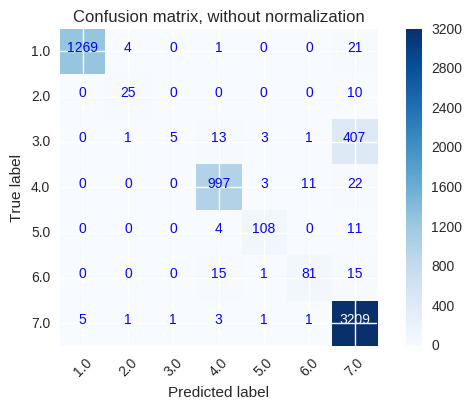

In [12]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "blue")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = np.unique(y_train[ix_lda])    
cnf_matrix = confusion_matrix(y_train[ix_lda], svm.predict(Y_lda))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()


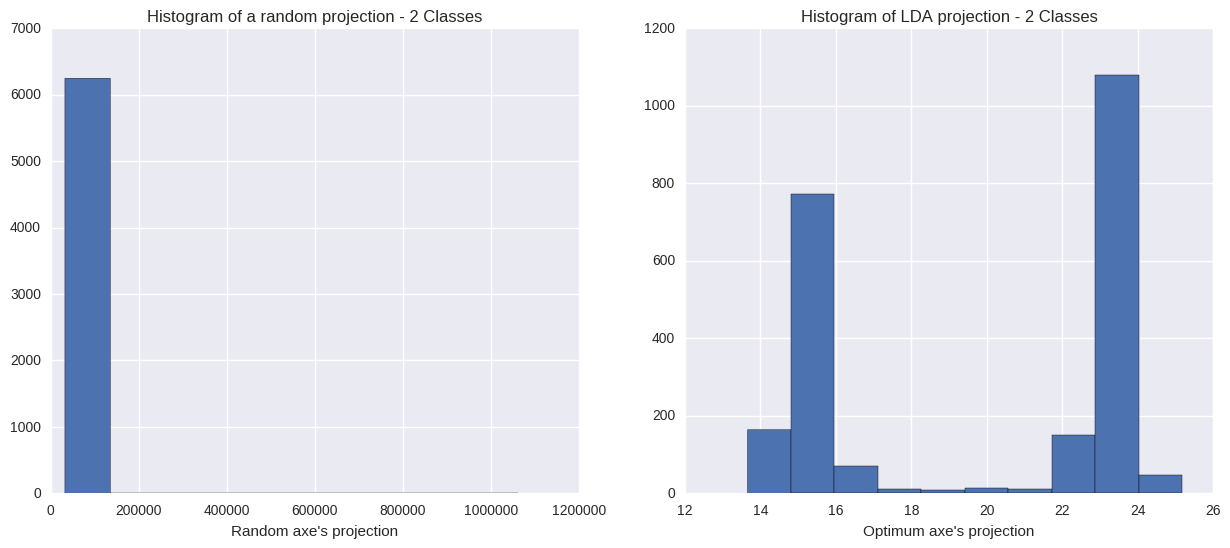

In [13]:
Y_lda, ix_lda,_ = lda(X_train_da,y_train, cla=[1,4])
N_features = X_train_da.shape[1]
random_vector = np.random.rand(1,N_features)
random_projection = np.dot(random_vector, X_train_da.T).T
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(random_projection)
plt.title("Histogram of a random projection - 2 Classes")
plt.xlabel("Random axe's projection")
# plt.ylabel("Number of a")
plt.subplot(122)
plt.hist(Y_lda)
plt.title("Histogram of LDA projection - 2 Classes")
plt.xlabel("Optimum axe's projection")
# plt.legend()

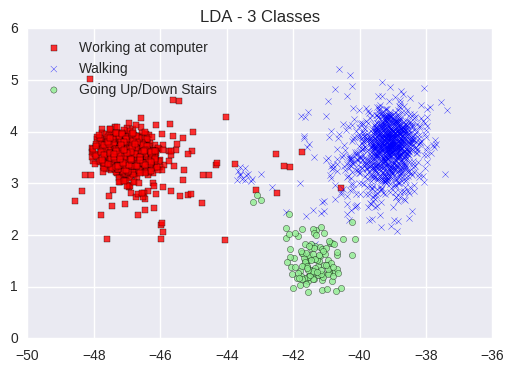

In [14]:
from matplotlib.colors import ListedColormap
Y_lda, ix_lda,_ = lda(X_train_da,y_train, cla=[1,4,5])
resolution=0.02
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')

cmap = ListedColormap(colors[:len(np.unique(y_train[ix_lda]))])


L = ['Working at computer', 'Walking', 'Going Up/Down Stairs']
for idx, cl in enumerate(np.unique(y_train[ix_lda])):
    
    plt.scatter(x=Y_lda[y_train[ix_lda] == cl, 0], y=Y_lda[y_train[ix_lda] == cl, 1],
    alpha=0.8, c=cmap(idx),
    marker=markers[idx], label=L[idx])
    
plt.legend(loc='upper left')
plt.title('LDA - 3 Classes')
plt.show()

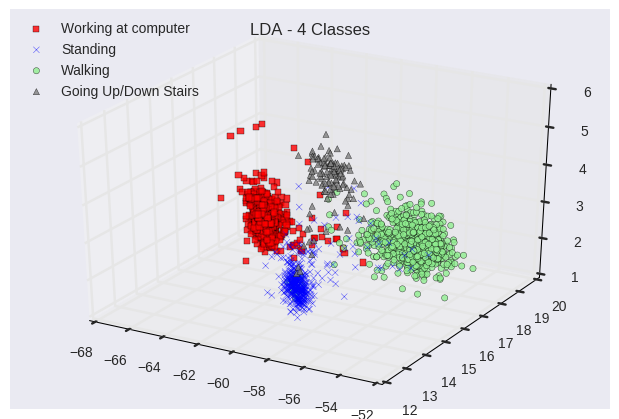

In [15]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
Y_lda, ix_lda,_ = lda(X_train_da,y_train, cla=[1,3,4,5])
resolution=0.02
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')

cmap = ListedColormap(colors[:len(np.unique(y))])


L = ['Working at computer', 'Standing','Walking', 'Going Up/Down Stairs']
fig = plt.figure()
ax = Axes3D(fig)
for idx, cl in enumerate(np.unique(y_train[ix_lda])):
    
    ax.scatter(Y_lda[y_train[ix_lda] == cl, 0], Y_lda[y_train[ix_lda] == cl, 1], Y_lda[y_train[ix_lda] == cl, 2],
               alpha=0.8, c=cmap(idx),
               marker=markers[idx], label=L[idx])
    
plt.legend(loc='upper left')
plt.title('LDA - 4 Classes')
plt.show()


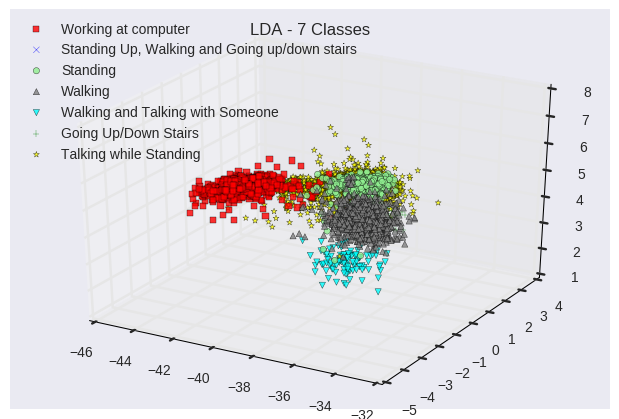

In [16]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
Y_lda, ix_lda,_ = lda(X_train_da,y_train, cla=None)
resolution=0.02
markers = ('s', 'x', 'o', '^', 'v','+','*')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan','green','yellow')

cmap = ListedColormap(colors[:len(np.unique(y))])


L = ['Working at computer', 'Standing Up, Walking and Going up/down stairs','Standing',
     'Walking', 'Walking and Talking with Someone',
     'Going Up/Down Stairs', 'Talking while Standing']
fig = plt.figure()
ax = Axes3D(fig)
for idx, cl in enumerate(np.unique(y_train[ix_lda])):
    ax.scatter(Y_lda[y_train[ix_lda] == cl, 0], Y_lda[y_train[ix_lda] == cl, 1], Y_lda[y_train[ix_lda] == cl, 2],
               alpha=0.8, c=cmap(idx),
               marker=markers[idx], label=L[idx])
    
plt.legend(loc='upper left')
plt.title('LDA - 7 Classes')
plt.show()


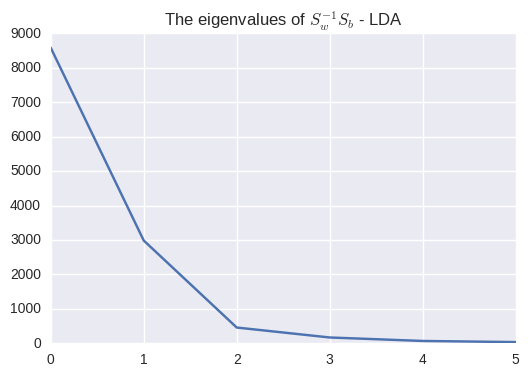

In [17]:
Y_lda, ix_lda,w = lda(X_train_da,y_train, cla=None)
plt.plot((np.abs(w[:6])))
plt.title('The eigenvalues of $S_w^{-1} S_b$ - LDA')

** KDA ** 

In [18]:
from sklearn.metrics.pairwise import rbf_kernel

def w_matrix(x1,x2):
    """ Matrix of i and j : 1/mk if i==j, 0 else"""
    n = len(x1)
    M = np.zeros((n,n))
    for i in range(n):
        mk =  len(np.where(y==y[i])[0])
        M[i,:] = np.equal(x1[i],x2).astype(int)*(1./mk)
    return M

def kda(X, y, cla = None):
    if cla==None:
        cla = np.unique(y)
        ix = np.in1d(y, cla)
    else :
        ix = np.in1d(y, cla)
        y = y[ix]
        X = X[ix]
        
    K=rbf_kernel(X,X)
    n = K.shape[0]
    W = w_matrix(y,y)
    # Within-class scatter matrix
    Sw = np.dot(K,K)
    # Between-class scatter matrix
    Sb = np.dot(K,np.dot(W,K))
    # Project Matrices
    Proj_dim = np.unique(y).shape[0]-1
    w,v =  np.linalg.eig(np.dot(np.linalg.inv(Sw),Sb))
    Alpha = np.real(v[:,0:Proj_dim])
    projected = np.dot(Alpha.T, K).T
    return projected, ix, w  

Y_kda, ix_kda,_ = kda(X_train_da,y_train, cla=None)

In [19]:
lr = LogisticRegressionCV()
lr.fit(Y_kda, y_train[ix_kda])
cv_kda_lr = min(cross_val_score(lr, Y_kda, y_train[ix_kda], cv=3))
print("KDA + Logistic Regression :"+str(cv_kda_lr))
print("Confusion Matrix : KDA + LR")
print(confusion_matrix(y_train[ix_kda], lr.predict(Y_kda)))
svm = SVC(C = 1500, kernel='linear')
svm.fit(Y_kda, y_train[ix_kda])
cv_kda_svm = min(cross_val_score(svm, Y_kda, y_train[ix_kda], cv=3))
print("KDA + SVM :"+str(cv_kda_svm))
print("Confusion Matrix : KDA + SVM")
print(confusion_matrix(y_train[ix_kda], svm.predict(Y_kda)))

KDA + Logistic Regression :0.925961538462
Confusion Matrix : KDA + LR
[[1295    0    0    0    0    0    0]
 [   0    0    0    0    0    0   35]
 [   0    0  430    0    0    0    0]
 [   0    0    0 1033    0    0    0]
 [   0    0    0    0  123    0    0]
 [   0    0    0    0    0  112    0]
 [   0    0    0    0    0    0 3221]]
KDA + SVM :0.994239078253
Confusion Matrix : KDA + SVM
[[1295    0    0    0    0    0    0]
 [  35    0    0    0    0    0    0]
 [   0    0  430    0    0    0    0]
 [   0    0    0 1033    0    0    0]
 [   0    0    0    0  123    0    0]
 [   0    0    0    0    0  112    0]
 [   0    0    0    0    0    0 3221]]


Confusion matrix, without normalization
[[1295    0    0    0    0    0    0]
 [  35    0    0    0    0    0    0]
 [   0    0  430    0    0    0    0]
 [   0    0    0 1033    0    0    0]
 [   0    0    0    0  123    0    0]
 [   0    0    0    0    0  112    0]
 [   0    0    0    0    0    0 3221]]


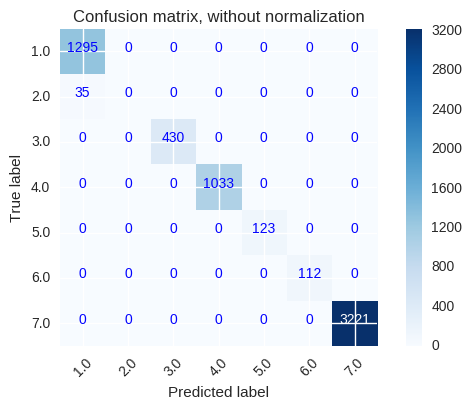

In [20]:
class_names = np.unique(y_train[ix_kda])    
cnf_matrix = confusion_matrix(y_train[ix_kda], svm.predict(Y_kda))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

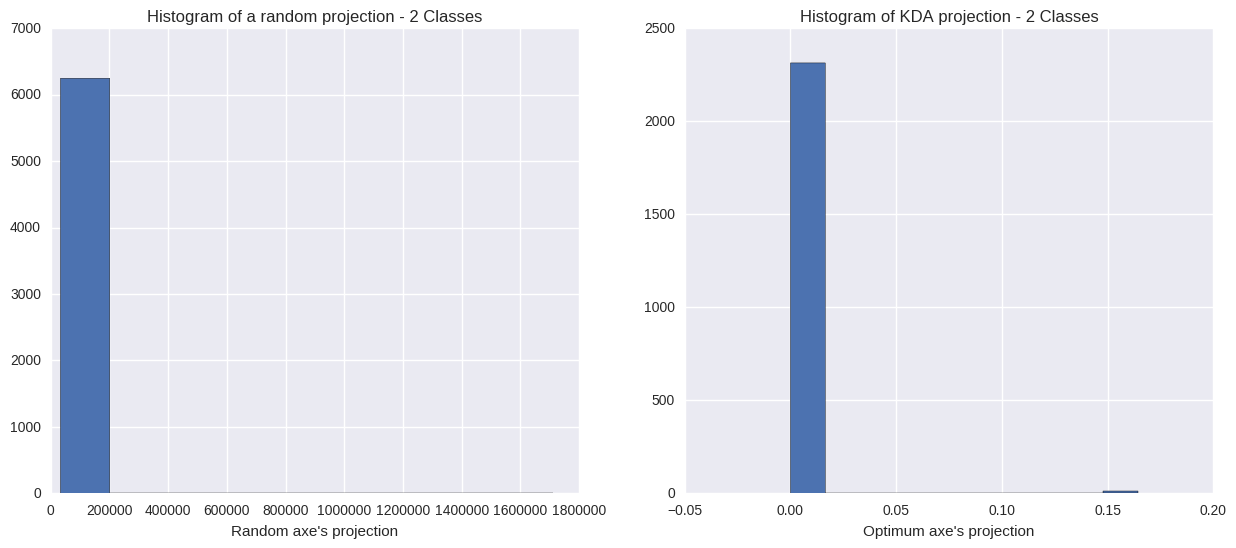

In [21]:
Y_kda, ix_kda,_ = kda(X_train_da,y_train, cla=[1,4])
N_features = X_train_da.shape[1]
random_vector = np.random.rand(1,N_features)
random_projection = np.dot(random_vector, X_train_da.T).T
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(random_projection)
plt.title("Histogram of a random projection - 2 Classes")
plt.xlabel("Random axe's projection")
plt.subplot(122)
plt.hist(Y_kda)
plt.title("Histogram of KDA projection - 2 Classes")
plt.xlabel("Optimum axe's projection")

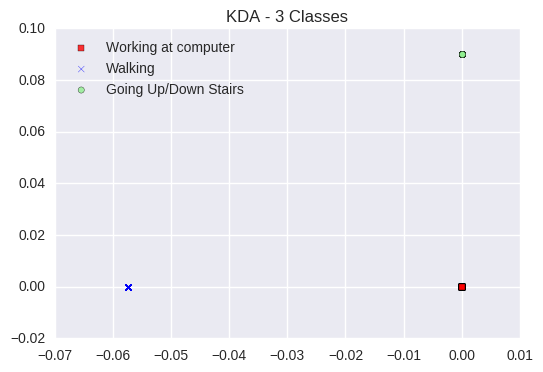

In [22]:
from matplotlib.colors import ListedColormap
Y_kda, ix_kda,_ = kda(X_train_da,y_train, cla=[2,3,5])
# fig = plt.figure()
# plt.scatter(Y_kda[:,0],Y_kda[:,1], c=y_train[ix_kda], cmap='viridis_r')
resolution=0.02
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')

cmap = ListedColormap(colors[:len(np.unique(y_train[ix_kda]))])

L = ['Working at computer', 'Walking', 'Going Up/Down Stairs']


for idx, cl in enumerate(np.unique(y_train[ix_kda])):
    
    plt.scatter(x=Y_kda[y_train[ix_kda] == cl, 0], y=Y_kda[y_train[ix_kda] == cl, 1],
    alpha=0.8, c=cmap(idx),
    marker=markers[idx], label=L[idx])
    
plt.legend(loc='upper left')
plt.title('KDA - 3 Classes')
plt.show()

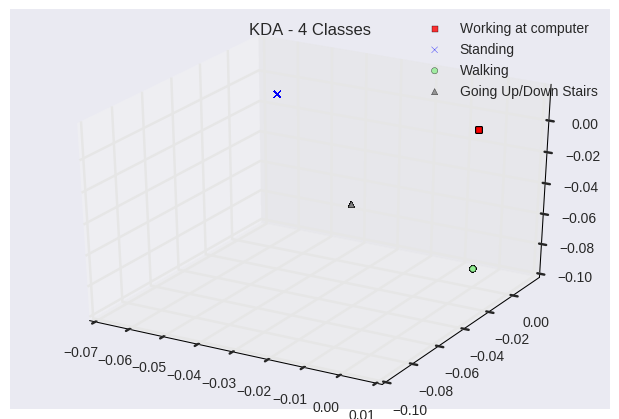

In [23]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
Y_kda, ix_kda,_ = kda(X_train_da,y_train, cla=[2,3,5,6])

# fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter(Y_kda[:,0],Y_kda[:,1], Y_kda[:,2], c=y_train[ix_kda], cmap='viridis_r')
resolution=0.02
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')

cmap = ListedColormap(colors[:len(np.unique(y_train[ix_kda]))])


L = ['Working at computer', 'Standing','Walking', 'Going Up/Down Stairs']
fig = plt.figure()
ax = Axes3D(fig)
for idx, cl in enumerate(np.unique(y_train[ix_kda])):
    
    ax.scatter(Y_kda[y_train[ix_kda] == cl, 0], Y_kda[y_train[ix_kda] == cl, 1], Y_kda[y_train[ix_kda] == cl, 2],
               alpha=0.8, c=cmap(idx),
               marker=markers[idx], label=L[idx])
    
plt.legend(loc='best')
plt.title('KDA - 4 Classes')
plt.show()


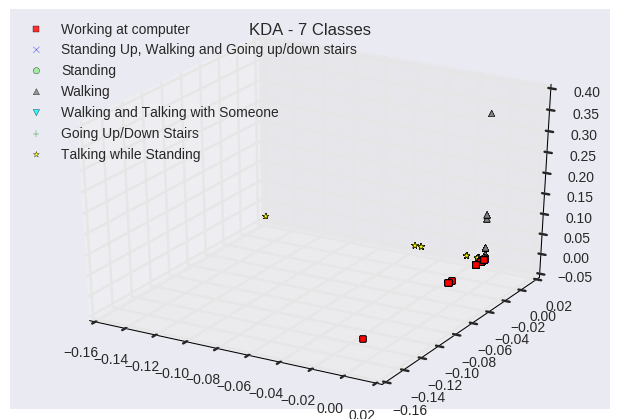

In [24]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
Y_kda, ix_kda,_ = kda(X_train_da,y_train, cla=None)
resolution=0.02
markers = ('s', 'x', 'o', '^', 'v','+','*')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan','green','yellow')

cmap = ListedColormap(colors[:len(np.unique(y))])


L = ['Working at computer', 'Standing Up, Walking and Going up/down stairs','Standing',
     'Walking', 'Walking and Talking with Someone',
     'Going Up/Down Stairs', 'Talking while Standing']
fig = plt.figure()
ax = Axes3D(fig)
for idx, cl in enumerate(np.unique(y_train[ix_kda])):
    
    ax.scatter(Y_kda[y_train[ix_kda] == cl, 0], Y_kda[y_train[ix_kda] == cl, 1], Y_kda[y_train[ix_kda] == cl, 2],
               alpha=0.8, c=cmap(idx),
               marker=markers[idx], label=L[idx])
    
plt.legend(loc='upper left')
plt.title('KDA - 7 Classes')
plt.show()


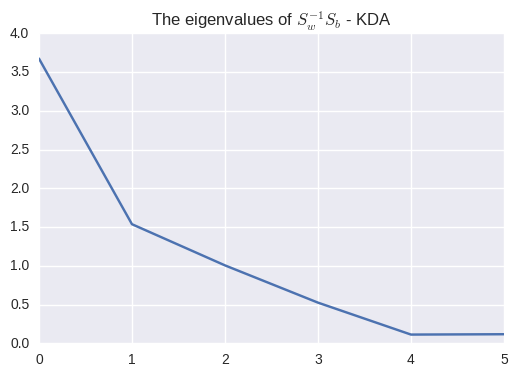

In [25]:
Y_kda, ix_kda, w = kda(X_train_da, y_train, cla=None)
plt.plot((np.abs(w[:6])))
plt.title('The eigenvalues of $S_w^{-1} S_b$ - KDA')